In [1]:
%load_ext autoreload
%autoreload 2

## Generating summaries

In [ ]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split, get_sample_weights, get_eval_set
from src.preprocessing import preprocess_data
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, AutoModelForCausalLM
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_auc_score
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
import transformers
import re
from src.utils import aggregate_samples, evaluate_model, compute_class_weights, remove_hashtag_links, get_first_texts
from torch.optim.lr_scheduler import ReduceLROnPlateau
import ast

import asyncio
from openai import OpenAI

tqdm.pandas()

import nest_asyncio
nest_asyncio.apply()

In [3]:
train_data, test_data = train_test_split()


100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


In [ ]:
df = pd.concat(train_data)

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096", )
df['tokens'] = df['Tweet'].progress_apply(tokenizer.tokenize)

target_words = [
    "goal", "penalty", "halftime", "full-time", "yellow", "red",
    "kickoff", "extra time", "stoppage time", "foul", "offside", "handball",
    "save", "tackle", "dribble", "corner", "substitution", "header",
    "free kick", "throw-in", "assist", "hat-trick", "own goal", "victory",
    "defeat", "draw", "win", "loss", "tie", "comeback", "goalkeeper",
    "striker", "midfielder", "defender", "referee", "fans", "var", "gooal"
]
target_words = set(tokenizer.tokenize(" ".join(target_words)))

def is_valid_text(t):
    for w in t:
        if w in target_words:
            return True
        
    return False

df['is_valid']= df['tokens'].progress_apply(is_valid_text)
# df['lan'] = df['Tweet'].progress_apply(lambda x : langid.classify(x)[0])

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

100%|██████████| 1472980/1472980 [00:03<00:00, 477241.97it/s]


In [6]:
valid_df = df.query("is_valid == 1")

## Checking timestamp

In [7]:
first_ts = valid_df.groupby(["MatchID", "PeriodID"]).Timestamp.min()
last_ts = valid_df.groupby(["MatchID", "PeriodID"]).Timestamp.max()

In [8]:
possible_indices = set(train_data.keys())

test_indices = list(np.random.choice(list(possible_indices), size=3, replace = False,))
test_indices = [13,1,18]
all_train_indices = list(possible_indices.difference(set(test_indices)))
val_indices = [1,5,12,19]
# val_indices = list(np.random.choice(all_train_indices, 3, replace=False))
# train_indices = list(set(all_train_indices).difference(set(val_indices)))
# train_indices = [0,2,7,11,13,18]



train_df = aggregate_samples(valid_df, list(possible_indices), max_size = 10)
test_df = aggregate_samples(valid_df, test_indices, max_size=10)
val_df = aggregate_samples(valid_df, val_indices, max_size=10)

train_df = remove_hashtag_links(train_df)
test_df = remove_hashtag_links(test_df)
val_df = remove_hashtag_links(val_df)

In [9]:
train_df

Tweet  \
MatchID PeriodID                                                      
0       0         Robbie Fowler predicting a Honduras win? \n le...   
        1         can  please win...\nLego Honduras and France !...   
        2         Hoy golea Costly. \nMy Predictions: \n 1-3 \n ...   
        3         Honduras better kick some ass\nCome on Hondura...   
        4         Honduras is taking the win lets go!!\nHonduras...   
...                                                             ...   
19      125       What a win!\n \nWe got this  win!!!\n 3-1   \n...   
        126       He'll yea 3-1 \n doing work \nGreat win  \n\n ...   
        127       FULL TIME!!!\n 1-3 \n\nCielito Lindo!  \nGood ...   
        128       Great win for \n for the win\n vs  lets go!\nW...   
        129       gonna win 1-0 against \nMexico will beat Nethe...   

                  EventType   ID  
MatchID PeriodID                  
0       0               0.0    9  
        1               0.0   17  
        2               0.0   17  
        3               0.0   19  
        4               0.0   18  
...                     ...  ...  
19      125             1.0  113  
        126             1.0  106  
        127             1.0   88  
        128             1.0   76  
        129             1.0   59  

[2137 rows x 3 columns]

In [150]:
base_prompt = ''' 


You are a helpful AI tasked with analyzing a collection of tweets posted during a single minute of a football match. Your goal is to generate a concise summary of the key events that occurred during this time and to specifically answer whether any of the following events occurred: 

1. A goal (including who scored, if mentioned).
2. A yellow or red card (including the player or team, if mentioned).
3. A kickoff (start of a half or after a goal).
4. Halftime or fulltime whistle.

Here are the tweets:

{tweets}

### Instructions:
1. Analyze the tweets for clear indications of the above events using common football-related terminology, phrases, or hashtags.
2. If the event is ambiguous or not explicitly stated in the tweets, mark it as "Not mentioned."
3. Summarize any additional significant match events or fan reactions from the tweets that are relevant to understanding the minute.
4. Return the response in the following structured format:

```
{{
    "summary": [What happened in that minute.],
    "goal": [yes/no/not mentioned if there was a goal on that exact minute. 
             If there was only a chance/attempt, return "no". 
             Add the tweet that refers to the goal.],
    "cards": [yes/no/not mentioned if there were any cards on that exact minute. 
              Add the tweet that refers to the card.],
    "kickoff": [yes/no/not mentioned if the match just started in that exact minute. 
                Add the tweet that refers to the kickoff.],
    "halftime": [yes/no/not mentioned if the first half ended in that exact minute. 
                 Add the tweet that refers to the halftime.],
    "fulltime": [yes/no/not mentioned if the game ended in that exact minute. 
                 Add the tweet that refers to the fulltime.]
}}
```
Try to reason as much as possible and avoid simple and quick answers

'''

In [151]:
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [92]:
client = OpenAI(
    api_key="E816LUcagzqnrKK49x99jFqzVlrEDKqr",
    base_url="https://api.deepinfra.com/v1/openai",
)


In [93]:
client = OpenAI(
    api_key="E816LUcagzqnrKK49x99jFqzVlrEDKqr",
    base_url="https://api.deepinfra.com/v1/openai",
)

async def create_completion(prompt, model_name, stream):
    try:
        chat_completion = await asyncio.to_thread(
            client.chat.completions.create,
            model=model_name,
            # prompt = prompt,
            messages=[{"role": "user", "content": prompt}],
            stream=stream,
        )

        if stream:
            for event in chat_completion:
                if event.choices[0].finish_reason:
                    print(
                        event.choices[0].finish_reason,
                        event.usage['prompt_tokens'],
                        event.usage['completion_tokens']
                    )
                else:
                    print(event.choices[0].delta.content)
            return None  # Return None for stream as the output is handled by the print statements
        else:
            generated_text = chat_completion.choices[0].message.content
            prompt_tokens = chat_completion.usage.prompt_tokens
            output_tokens = chat_completion.usage.completion_tokens
            return {
                "generated_text": generated_text,
                "prompt_tokens": prompt_tokens,
                "output_tokens": output_tokens
            }
    except Exception as e:
        print(f"Error during OpenAI API request: {e}")
        return None

async def process_completions(study_df, model_name, stream, batch_size=1_000):
    generated_texts = []
    
    tasks = []
    for i, (text_idx, row) in enumerate(study_df.iterrows()):
        prompt = base_prompt.format(tweets=row['Tweet'])
        tasks.append((i, text_idx, row, create_completion(prompt, model_name, stream)))

    for batch_start in range(0, len(tasks), batch_size):
        batch = tasks[batch_start:batch_start + batch_size]
        results = await asyncio.gather(*[task[3] for task in batch])
        
        for (i, text_idx, row, _), result in zip(batch, results):
            if result is not None:
                generated_text = result['generated_text']
                prompt_tokens = result['prompt_tokens']
                output_tokens = result['output_tokens']
                
                clear_output(wait=True)
                print(
                    f"""
                    Generation of text index = {i}
                    Generated text = {generated_text}
                    Number of prompt tokens = {prompt_tokens}
                    Number of output tokens = {output_tokens}
                    """
                )

                generated_texts.append({
                    "generated_text": generated_text,
                    "text": row['Tweet'],
                    "text_idx": text_idx,
                    "label": row["EventType"]
                })

    return generated_texts

async def main():
    # Define your study_df, model_name, stream, and other necessary variables
    stream = False  # Change to True if you want streaming

    # Run the process_completions coroutine
    generated_texts = await process_completions(train_df, model_name, stream, batch_size=1)
    return generated_texts

# Run the async main function
generated_texts = asyncio.run(main())

KeyboardInterrupt: 

In [49]:
generated_texts = pd.read_csv("generated_summary_llm_2.csv", index_col = 0)

In [65]:
generated_texts['preds'] = generated_texts['generated_text'].str.lower().str.contains("yes").astype(int)

In [59]:
generated_texts['text_idx'] = generated_texts['text_idx'].apply(ast.literal_eval)

In [60]:
generated_texts['match_id'] = generated_texts['text_idx'].apply(lambda x: x[0])
generated_texts['period_id'] = generated_texts['text_idx'].apply(lambda x: x[1])



In [73]:
generated_texts.groupby("match_id").apply(lambda x: accuracy_score(x['label'], x['preds']))

/tmp/ipykernel_1791824/1139202758.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  generated_texts.groupby("match_id").apply(lambda x: accuracy_score(x['label'], x['preds']))


match_id
0     0.730769
1     0.600000
2     0.753846
3     0.607692
4     0.594118
5     0.561538
7     0.615385
8     0.753846
10    0.627778
11    0.646154
12    0.649485
13    0.607692
14    0.576923
17    0.584615
18    0.669231
19    0.623077
dtype: float64

In [96]:
print(generated_texts.query("match_id == 1")['generated_text'].iloc[69])

Here's the analysis of the tweets:

**Summary**: Brazil was getting dominated by Germany, with fans expressing their disappointment and frustration. Some tweets made light of the situation with humorous comments.

**Event Analysis**


```json
{
    "summary": [
        "Brazil is getting dominated by Germany, fans are disappointed and frustrated.",
        "Some fans are making light of the situation with humorous comments."
    ],
    "goal": ["yes", "Brazil got German Whipped (Tweet 7)", "Brazil have been blitzkrieged (Tweet 16,18)"],
    "cards": ["no"],
    "kickoff": ["no"],
    "halftime": ["no"],
    "fulltime": ["no"]
}
```

Based on the tweets, there is a clear indication that a goal was scored by Germany in that exact minute, as mentioned in tweet 7 and tweets 16 and 18. The tweets do not explicitly mention a yellow or red card, kickoff, halftime, or fulltime whistle in that exact minute.


<Axes: xlabel='period_id'>

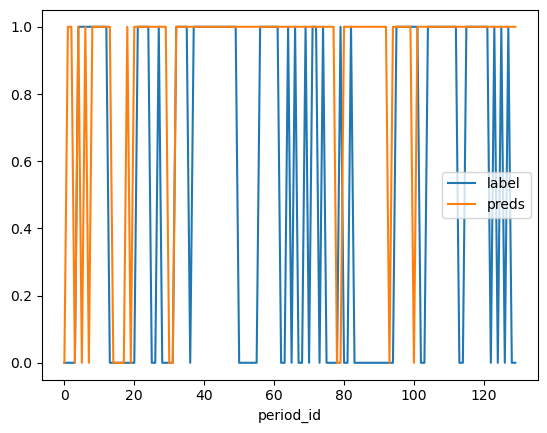

In [83]:
generated_texts.set_index("period_id").query("match_id == 1")[['label', 'preds']].plot()

### Generating predictions

In [146]:
eval_df = get_eval_set()

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
eval_df['tokens'] = eval_df['Tweet'].progress_apply(tokenizer.tokenize)

target_words = [
    "goal", "penalty", "halftime", "full-time", "yellow", "red",
    "kickoff", "extra time", "stoppage time", "foul", "offside", "handball",
    "save", "tackle", "dribble", "corner", "substitution", "header",
    "free kick", "throw-in", "assist", "hat-trick", "own goal", "victory",
    "defeat", "draw", "win", "loss", "tie", "comeback", "goalkeeper",
    "striker", "midfielder", "defender", "referee", "fans", "var", "gooal"
]
target_words = set(tokenizer.tokenize(" ".join(target_words)))

def is_valid_text(t):
    for w in t:
        if w in target_words:
            return True
        
    return False

eval_df['is_valid']= eval_df['tokens'].progress_apply(is_valid_text)
# df['lan'] = df['Tweet'].progress_apply(lambda x : langid.cl

100%|██████████| 362397/362397 [00:00<00:00, 452505.40it/s]


In [147]:
eval_df['EventType'] = -1

In [176]:
preprocessed_eval_df = aggregate_samples(eval_df.query("is_valid == 1"), eval_df.MatchID.unique().tolist(), max_size=10)

preprocessed_eval_df = remove_hashtag_links(preprocessed_eval_df)

In [177]:
preprocessed_eval_df

Tweet  \
MatchID PeriodID                                                      
6       0         Let's gooooo\nlet's go \nLet's go \nLet's go! ...   
        1         Let's go!\nLet's go 󾓨\n let's gooooooooo\nLet'...   
        2         Let's goooo \nReal game time. \nGERMANY must w...   
        3         Just in time.\n\nOzil-lean  \nLet's goooooooo ...   
        4         Lets go Germany!!\n\nLet's gooooooooo!!!! \nLe...   
...                                                             ...   
16      125       Let's go USA!!! \n  Vidic slo-mo, great! \nUSA...   
        126       Fick Mich\n \nLet's go ! \nLets go  \nhats off...   
        127       lets goooo !!! \nLet's go ! \n  let's gooooo!!...   
        128       Let's go Usa!!! \nLet's go  \n  its go time!\n...   
        129       Serbia win?wow...unexpected,hm? \n beat  1-0 \...   

                  EventType   ID  
MatchID PeriodID                  
6       0              -1.0   82  
        1              -1.0   85  
        2              -1.0   79  
        3              -1.0  110  
        4              -1.0  151  
...                     ...  ...  
16      125            -1.0  137  
        126            -1.0  115  
        127            -1.0  116  
        128            -1.0  109  
        129            -1.0   94  

[516 rows x 3 columns]

In [178]:
async def main():
    # Define your study_df, model_name, stream, and other necessary variables
    stream = False  # Change to True if you want streaming

    # Run the process_completions coroutine
    generated_texts = await process_completions(preprocessed_eval_df, model_name, stream, batch_size=1000)
    return generated_texts

# Run the async main function
generated_texts = asyncio.run(main())


                    Generation of text index = 515
                    Generated text = ## Analyzed Tweets for Football Match Minute

### Event Summary
The tweets indicate that the match between Serbia and Germany is ongoing. There are various reactions from fans, such as "wow...unexpected,hm?!" and "Wooooo!!!", suggesting a surprising outcome for Serbia. However, the accuracy of the score changes needs verification, as some tweets suggest a score change that might not be relevant to the exact minute in question.

### Event Details

#### Goal
- Status: yes
- Details: Serbia wins 1-0.
- Reference Tweet: "Serbia win?wow...unexpected,hm? beat 1-0"

#### Cards
- Status: not mentioned
- Details: No clear indications of any yellow or red cards were found in the tweets.

#### Kickoff
- Status: not mentioned
- Details: Although there are mentions of "5 hours to kick of" and "Five hours till kick-off!!!!", these appear to be referencing an upcoming match rather than a kickoff occurring in that

In [179]:
eval_df_generated = pd.DataFrame(generated_texts)

In [196]:
idx = np.random.randint(0, len(eval_df_generated))
print(eval_df_generated['text'].iloc[idx])

Mexico's keeper: unbelieveble
Mexico is just ballin
lets facken go holland
Seriously Netherlands?! Lets goooo!
One more goal Mexico!!!!!!!
mexico going to win
Another offside  goal.
Mexico playin good doe
Come Dutch, win this
Ugh, Mexico can't win!
One more goal Mexico!
I hope the netherlands win
Mexico can't win this game.
Holland make a goal now
let's go Mexico!  
Mexico scoreee (but its offside)
I'm diggin Mexico's goalies hair
Offside  VS  
the dutch goalkeeper looks terrified
i S2G  better win
Hahahaha this Dutch goalkeeper nahhh
Mexico scored a goal. Cool
Mexico parking their bus lmaooooo
Let's go my fellow Dutch
Mexico deserves this win 
First time rooting against Holland...
C'mon mexico make another goal!!
Mexico need another goal fast
Mexico goal keeper. Great hair.
Holland let's goo!! Score already
mexico have been top draw
Feeling a holland goal here.
Mexico ISN'T takin the win.
: 66'  0-1 
 
Mexico & Greece have to win‼
Mexico we need a second goal
Goalllllllll goallllllll 

In [197]:
print(eval_df_generated['generated_text'].iloc[idx])

After analyzing the tweets, I have the following findings:

* **Summary:** The tweets suggest that Mexico and the Netherlands were engaged in a closely contested football match. There were many expressions of excitement, support, and frustration from fans on both sides. Mexico seemed to be dominating the game, with fans calling for their team to score another goal. There were also comments about the Dutch team's performance and their need for a better striker.
* **Goal:** Yes. Mexico scored a goal. (Tweet: "Mexico scored a goal. Cool")
* **Cards:** Not mentioned. There were no mentions of yellow or red cards in the tweets during this minute.
* **Kickoff:** Not mentioned. While there are mentions of a kickoff earlier in the game (tweets like ": 66'  0-1" suggest that a kickoff may have occurred around this time), there is no explicit mention of a kickoff in the tweets during this exact minute.
* **Halftime:** Not mentioned. The tweets do not mention the halftime whistle or the end of th

In [184]:
eval_df_generated['EventType'] = eval_df_generated['generated_text']\
    .str\
    .lower()\
    .str\
    .contains("yes")\
    .astype(int)

In [185]:
eval_df_generated['MatchID'] = eval_df_generated['text_idx'].apply(lambda x : x[0])
eval_df_generated['PeriodID'] = eval_df_generated['text_idx'].apply(lambda x : x[1])

In [186]:
x = eval_df.drop_duplicates("ID")[['ID', "MatchID", "PeriodID"]]

In [174]:
pd.merge(
    eval_df_generated,
    x,
    on = ['MatchID', "PeriodID"]
    
)[["ID", "EventType"]]\
    .set_index("ID")\
    .to_csv("predictions_3.csv")

In [188]:
eval_df_generated['EventType'].value_counts(normalize=True)

1    0.728682
0    0.271318
Name: EventType, dtype: float64